In [1]:
%matplotlib inline
import csv
import os
import glob
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
object_observed ="Calibration Source"
frequency = "2215.00"

In [3]:
def datetime_to_mjd(t):
    mjd_epoch=np.datetime64('1858-11-17T00:00:00')
    time_differences = t - mjd_epoch
    mjd_values = time_differences / np.timedelta64(1, 'D')
    return mjd_values

def find_peak_frequencies(xy, frequency_values):
    magnitudes = np.abs(xy)    
    peak_frequency_indices = np.argmax(magnitudes, axis=1)
    peak_frequencies = frequency_values[peak_frequency_indices]
    return peak_frequencies

In [4]:
# plot variables
mark_size = 5

# gnuradio settings
nfft = 4096
samp_rate = 1e6
decim1 = 16
integ = 10

integrate = int(samp_rate/decim1/nfft*integ)
print(integrate) # print this to double check :-)

#observation details
site = 8049

directory_path = '/home/scott/blade_test/'

filename_pattern = '*.xx.f32'

latest_file = max(glob.glob(os.path.join(directory_path, filename_pattern)), key=os.path.getctime)

filename_parts = os.path.basename(latest_file).split('.')[0].split('_')
date_str = filename_parts[0]  # Format: yyyy-mm-ddThh:mm:ss

date_format = "%Y-%m-%dT%H:%M:%S"
datetime_obj = datetime.strptime(date_str, date_format)
formatted_datetime = datetime_obj.strftime("%Y-%m-%dT%H:%M:%S")

xx = np.fromfile(os.path.join(directory_path, f'{formatted_datetime}.xx.f32'), dtype='float32').reshape((-1, nfft))
yy = np.fromfile(os.path.join(directory_path, f'{formatted_datetime}.yy.f32'), dtype='float32').reshape((-1, nfft))
xy = np.fromfile(os.path.join(directory_path, f'{formatted_datetime}.xy.c64'), dtype='complex64').reshape((-1, nfft))

t = np.arange(xx.shape[0]) * integrate * nfft * decim1 / samp_rate * 1e3 * np.timedelta64(1, 'ms') + np.datetime64(datetime_obj)
print("Latest Filename:", latest_file)
print("Datetime:", datetime_obj)


152
Latest Filename: /home/scott/blade_test/2023-10-21T20:16:51.xx.f32
Datetime: 2023-10-21 20:16:51


0.70205855
peak frequency 2215003906.25
Column Index for Peak Value: 2304
Gain Offset: 0.70205855
shape of XY:  (34, 4096)
Column Index for Peak Value: 2304
Complex Phase Angle (Degrees) of Peak Value: -164.7868104818851
peak frequency 2215003906.25


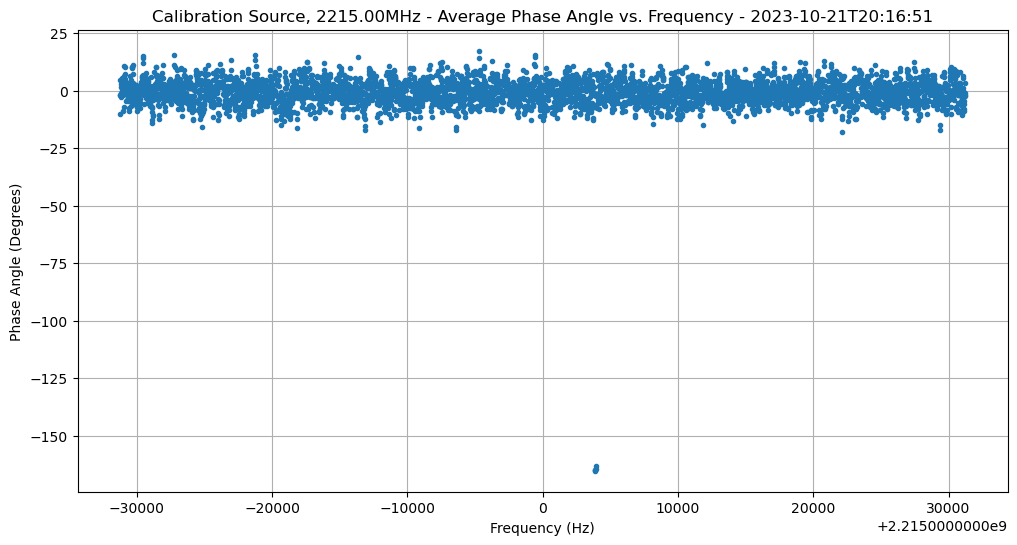

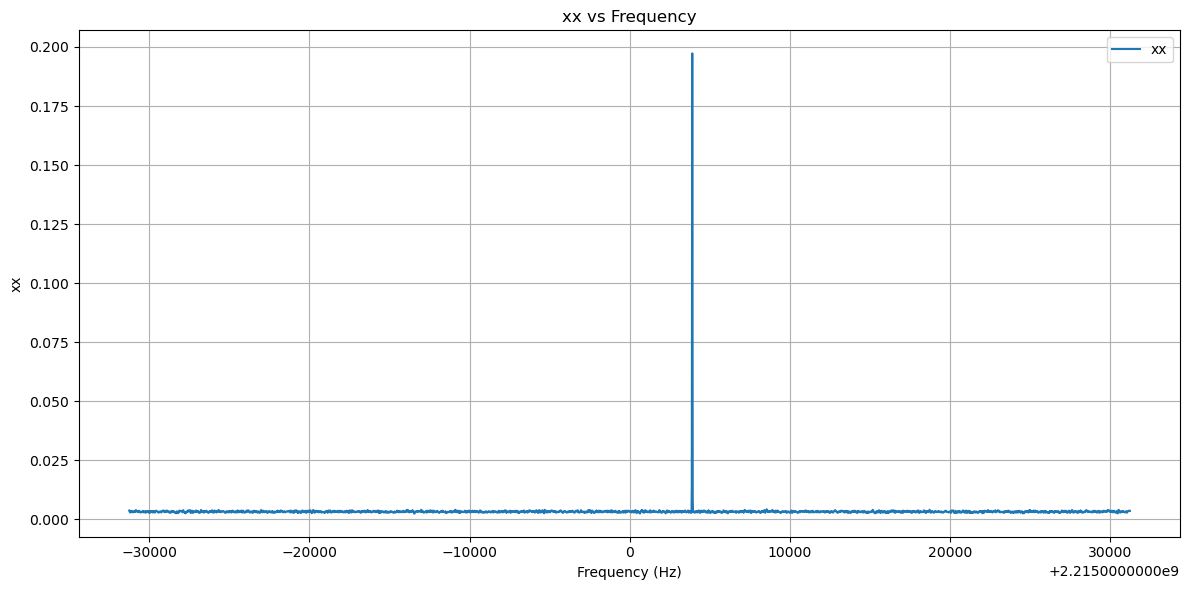

In [5]:
frequency_values = np.arange((samp_rate/decim1)/-2.0, (samp_rate/decim1)/2.0, (samp_rate/decim1)/nfft)
frequency_values += float(frequency) *1e6

peak_column_index = np.argmax(np.max(np.abs(xx), axis=0))
xx_peak = xx[:, peak_column_index]
yy_peak = yy[:, peak_column_index]
gain_offset = np.average(xx_peak / yy_peak)
print(gain_offset)

print("peak frequency", frequency_values[peak_column_index])
print("Column Index for Peak Value:", peak_column_index)
print("Gain Offset:", gain_offset)
print("shape of XY: ", np.shape(xy))
yy *= gain_offset
xy *= np.sqrt(gain_offset)

n_rows,n_col = xy.shape
avg_complex_value = 0
for _ in range(n_rows):
    avg_complex_value += np.mean(xy, axis=0)
avg_complex_value /= n_rows
peak_value = np.max(np.abs(avg_complex_value))
peak_column_index = np.argmax(np.abs(avg_complex_value)) 
phase_angle_degrees = np.angle(avg_complex_value[peak_column_index], deg=True)
print("Column Index for Peak Value:", peak_column_index)
print("Complex Phase Angle (Degrees) of Peak Value:", phase_angle_degrees)

print("peak frequency", frequency_values[peak_column_index])

plt.figure(figsize=(12, 6))
plt.plot(frequency_values, np.angle(avg_complex_value, deg=True), '.')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase Angle (Degrees)')
plt.title(f'{object_observed}, {frequency}MHz - Average Phase Angle vs. Frequency - {formatted_datetime}')
plt.grid(True)

#Iterate phase angle offset until Q and V are zeroed out.
xy *= np.exp(-1j*np.deg2rad(-74.5))*(-1j) # correct for X-Y phase offset

plt.figure(figsize=(12, 6))
plt.plot(frequency_values, xx[-1, :], label='xx', markersize=mark_size)
plt.title('xx vs Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('xx')
plt.grid(True)
plt.legend()
plt.tight_layout()



In [6]:
signal_peak = np.argmax(xx + yy, axis = 1)
offsets = np.arange(-2,3)
signal_xx = np.zeros(xx.shape[0])
signal_yy = np.zeros(yy.shape[0])
signal_xy = np.zeros(xy.shape[0], dtype = 'complex')
for offset in np.arange(-2,3):
    signal_xx += xx[np.arange(signal_peak.shape[0]), signal_peak + offset]
    signal_yy += yy[np.arange(signal_peak.shape[0]), signal_peak + offset]
    signal_xy += xy[np.arange(signal_peak.shape[0]), signal_peak + offset]
signal_xx /= offsets.size
signal_yy /= offsets.size
signal_xy /= offsets.size
gain_xx_yy = np.median(signal_xx + signal_yy)
signal_xx /= gain_xx_yy
signal_yy /= gain_xx_yy
signal_xy /= gain_xx_yy

In [7]:
I = signal_xx + signal_yy
Q = signal_xx - signal_yy
U = 2*signal_xy.real
V = -2*signal_xy.imag
L = Q + 1j*U
P = np.sqrt(Q**2 + U**2 + V**2)

Text(0.5, 1.0, 'Calibration Source 2215.00MHz Stokes Parameters, 2023-10-21T20:16:51')

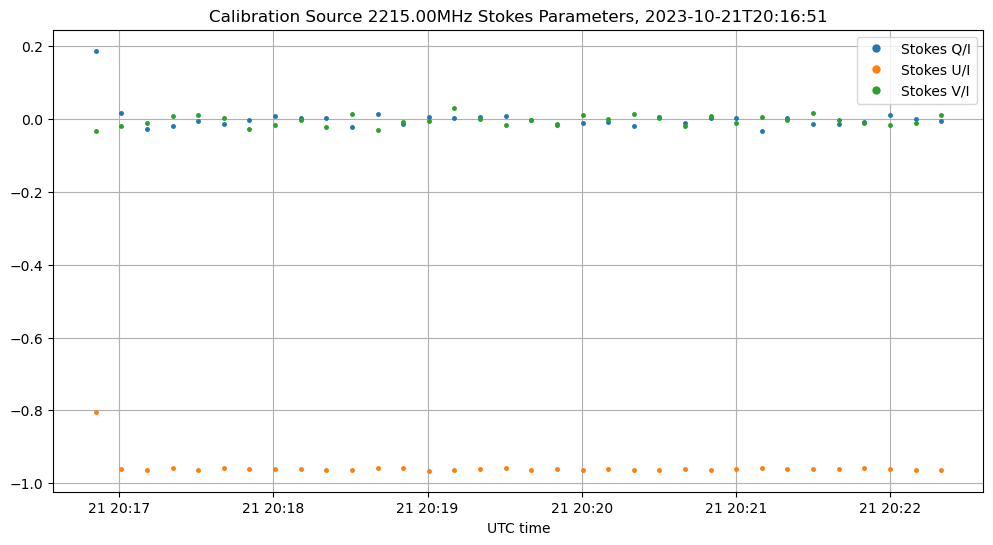

In [8]:
mark_size = 5
plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(t, (Q/I), '.', markersize=mark_size)
plt.plot(t, (U/I), '.', markersize=mark_size)
plt.plot(t, (V/I), '.', markersize=mark_size)
legend = plt.legend(['Stokes Q/I', 'Stokes U/I', 'Stokes V/I'])
for handle in legend.legendHandles:
    handle.set_markersize(10)  # Adjust the marker size as needed
plt.xlabel('UTC time')
title_text = f'{object_observed} {frequency}MHz Stokes Parameters, {formatted_datetime}'
plt.title(title_text)

Text(0.5, 1.0, 'Calibration Source 2215.00MHz Linear Polarization, 2023-10-21T20:16:51')

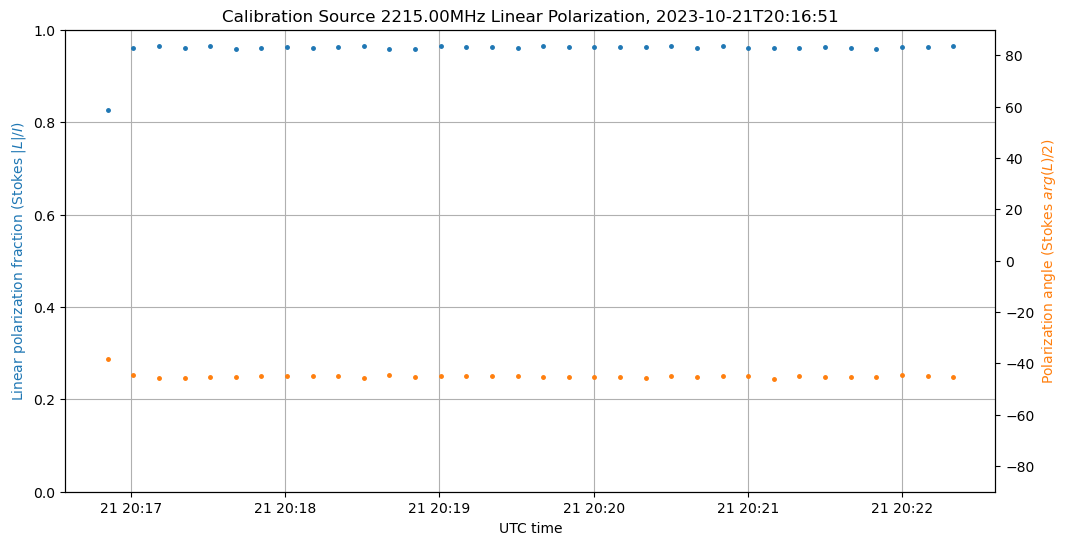

In [9]:
plt.figure(figsize = (12, 6))
plt.plot(t, (np.abs(L)/I), '.', markersize=mark_size)
plt.grid(True)
plt.ylim((0,1))
plt.xlabel('UTC time')
plt.ylabel('Linear polarization fraction (Stokes $|L|/I$)', color = 'C0')
ax2 = plt.gca().twinx()
plt.plot(t, np.rad2deg(np.angle(L)/2), '.', color = 'C1', markersize=mark_size)
ax2.set_ylabel('Polarization angle (Stokes $arg(L)/2$)', color = 'C1')
ax2.set_ylim((-90,90))
title_text = f'{object_observed} {frequency}MHz Linear Polarization, {formatted_datetime}'
plt.title(title_text)

Text(0.5, 1.0, 'Calibration Source 2215.00MHz Stokes Q 2023-10-21T20:16:51')

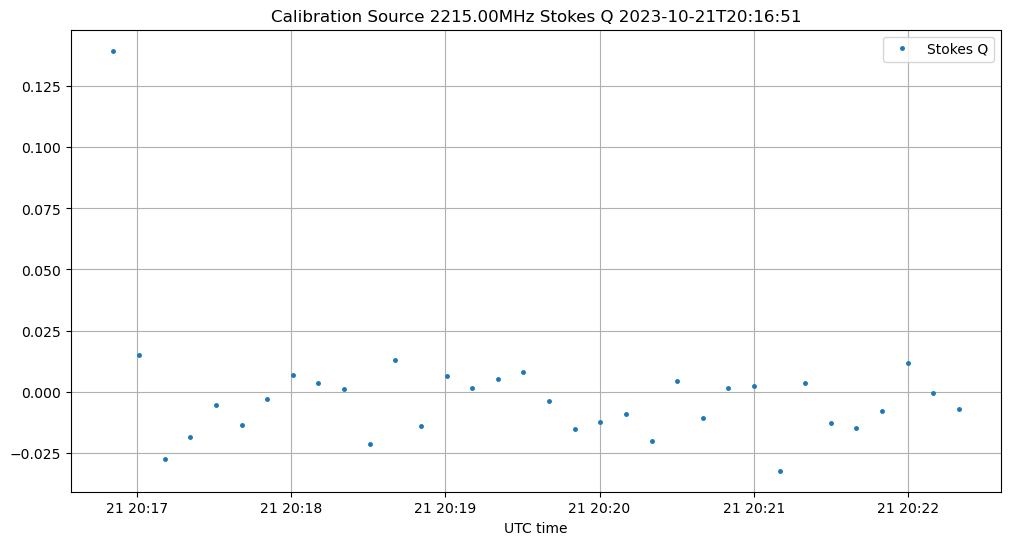

In [10]:
mark_size = 5
plt.figure(figsize = (12, 6))
plt.grid(True)
plt.plot(t, Q,'.',  markersize=mark_size)
plt.legend(['Stokes Q'])
plt.xlabel('UTC time')
title_text = f'{object_observed} {frequency}MHz Stokes Q {formatted_datetime}'
plt.title(title_text)


Text(0.5, 1.0, 'Calibration Source 2215.00MHz Stokes V, 2023-10-21T20:16:51')

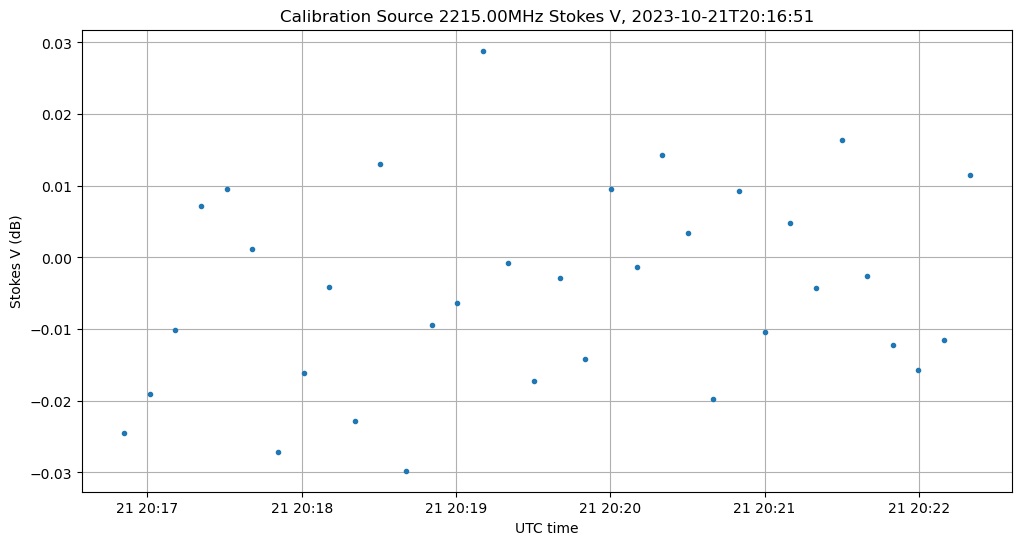

In [11]:
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(t, V, '.')
plt.xlabel('UTC time')
plt.ylabel('Stokes V (dB)')
title_text = f'{object_observed} {frequency}MHz Stokes V, {formatted_datetime}'
plt.title(title_text)
